# Hugging Face Library 'Transformer'およびT5Tokenizerのダウンロード

参考( https://qiita.com/takubb/items/fd972f0ac3dba909c293 )これを基に改造し、最新のGoogle Colaboratoryで動作するようにした

In [1]:
import argparse
import wandb

parser = argparse.ArgumentParser(description='liBERTy testbed')
#tp = lambda x:list(map(str, x.split(',')))
parser.add_argument('-l', '--num_of_learn', type=int, default=100,
    help='number (default 100) of learn, which determins the rate of dataset for the use of learning.')
parser.add_argument('-v', '--num_of_validation', type=int, default=100,
    help='number of validation to shorten the validation time.')
parser.add_argument('-e', '--max_epoch', type=int, default=20, 
    help='number (default 20) of epoch to be executed for learning loop')
parser.add_argument('-b', '--batch_size', type=int, default=64, 
    help='size (defaualt 64) of batch for learning process')
parser.add_argument('-a', '--article_type', type=int, default=0, choices=[0,1], 
    help='article type (0: dokujo_it=default, 1:dokujo_peachy')
parser.add_argument('-t', '--transformflags', default = 'n', #default='rids', 
    help='NLP-JP transformer (default n) r:synreplace i:randinsert d:randdelete s:randswap n:none')
parser.add_argument('-r', '--synreplace_rate', type=int, default=1, 
    help='rate (default 1) of synreplace_rate par sentence as int for transformers.')
parser.add_argument('-i', '--randinsert_rate', type=int, default=3, 
    help='rate (default 3) of randinsert of dataset par sentence as int for transformers.')
parser.add_argument('-d', '--randdelete_rate', type=float, default=0.15, 
    help='probability (default 0.15) of lranddelete in a sentence as float of dataset for transformers.')
parser.add_argument('-s', '--randswap_rate', type=int, default=2, 
    help='rate (default 2) of randswap of dataset per sentence as int for transformers.')
parser.add_argument('-f', '--jupyter', default='CMD', 
    help='executed from jupyter')
args = parser.parse_args()

if args.jupyter == 'CMD':
    numof_learn = args.num_of_learn
    numof_validation = args.num_of_validation
    max_epoch = args.max_epoch
    batch_size = args.batch_size
    transformflags = args.transformflags
    synreplace_rate = args.synreplace_rate
    randinsert_rate = args.randinsert_rate
    randdelete_rate = args.randdelete_rate
    randswap_rate = args.randswap_rate
    articletype = args.article_type
else:
    numof_learn = 100
    numof_validation = 200
    max_epoch = 20
    batch_size = 64
    transformflags = list('n') #'rids'
    synreplace_rate = 1
    randinsert_rate = 3
    randdelete_rate = 0.15
    randswap_rate = 2   
    articletype = 0
articlelabel = ['dokujo_it', 'dokujo_peachy']
print("num_of_learn:",numof_learn," max_epoch:", max_epoch," num_of_batch:", batch_size,
      " articletype:", articlelabel[articletype])
filestr = "l:"+str(numof_learn)+"_e:"+str(max_epoch)+"_b:"+str(batch_size)+"_t:"+transformflags+\
    "_r:"+str(synreplace_rate)+'_i:'+str(randinsert_rate)+'_d:'+str(randdelete_rate)+'_s:'+str(randswap_rate)+\
    "_a:"+articlelabel[articletype]
print(filestr)
transformflags = list(transformflags)

num_of_learn: 100  max_epoch: 20  num_of_batch: 64  articletype: dokujo_it
l:100_e:20_b:64_t:n_r:1_i:3_d:0.15_s:2_a:dokujo_it


In [2]:
#!export CUDA_LAUNCH_BLOCKING=1
# !pip install torch
#!pip install torchvision
#!pip install transformers
#!apt install swig
#!pip install sentencepiece
#!pip install mecab-python3
from transformers import T5Tokenizer
tokenizer = T5Tokenizer.from_pretrained("rinna/japanese-roberta-base")
tokenizer.do_lower_case = True  # due to some bug of tokenizer config loading

In [3]:
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"  # pytorchを同期実行させる
#os.environ['KMP_DUPLICATE_LIB_OK']='TRUE' # ライブラリ重複を無視
import gzip
import shutil
import random
from math import ceil
import re
import csv
import glob
import torchvision
import statistics
import numpy as np
import statistics
import MeCab
import copy
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

# PyTorchとGPU設定

In [4]:
#!pip install torch
import torch
# GPUが使えれば利用する設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
def torch_fix_seed(seed=24):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
torch_fix_seed()

# Data Augmentation kansuu

In [5]:
from transformers import RobertaForMaskedLM
robertamodel = RobertaForMaskedLM.from_pretrained("rinna/japanese-roberta-base")

In [6]:
# synreplace - replace kasho kosuu
# randinsert - tasu kotoba no kazu
# randdelete - delete kakuritsu
# randswap - swap kaisuu

class synreplace(object):
    def __init__(self, num):
        self.num = num
    def __call__(self, textlist):
        # textlist: honbun no list
        if len(torch.where(textlist == 3)[0]):
            textlen = torch.where(textlist == 3)[0][0]
        else:
            textlen = len(textlist)
        for n in range(self.num):
            # chikan shiro
            masked_idx = random.randint(2, textlen-1)
            textlist[masked_idx] = 6
            # convert to tensor
            token_tensor = torch.tensor(textlist)
            # get the top 10 predictions of the masked token
            self.model = robertamodel.eval()
            with torch.no_grad():
                outputs = robertamodel(torch.unsqueeze(token_tensor, 0))
                predictions = outputs[0][0, masked_idx].topk(1)
            for i, index_t in enumerate(predictions.indices):
                index = index_t.item()
            textlist[masked_idx] = index
        return textlist

class randinsert(object):
    def __init__(self, num):
        self.num = num
    def __call__(self, textlist):
        for n in range(self.num):
            insword = textlist[random.randint(1,len(textlist)-1)]
            i = random.randint(1,len(textlist)-1)
#            print('len: ', len(textlist))
#            print(i)
            while textlist[i] == 3:
                i = random.randint(1,len(textlist)-1)
#                print(i)
            textlist = torch.cat([textlist[0:i], torch.tensor([insword]), textlist[i:-1]])
        return textlist

class randdelete(object):
    def __init__(self, num):
        self.num = num
    def __call__(self, textlist):
#        print(textlist.shape)
        for i in range(3,len(textlist)-1):
            if textlist[i] == 3:
                continue
            r = random.uniform(0, 1)
            if r < self.num:
#                textlist.pop(i)
                textlist = torch.cat([textlist[0:i], textlist[i+1:], torch.tensor([3])])
#                print(textlist)
        return textlist

class randswap(object):
    def __init__(self, num):
        self.num = num
    def __call__(self, textlist):
        counter = 0
        #rs_sents = np.zeros(len(textlist), dtype=object)
        for i in range(len(textlist)):
            while self.num > counter:
                box = 0
                random_idx_1 = random.randint(1, len(textlist)-1)
                while textlist[random_idx_1] == 3:
                    random_idx_1 = random.randint(0, len(textlist)-1)
                random_idx_2 = random.randint(1, len(textlist)-1)
                while random_idx_1 == random_idx_2 or textlist[random_idx_2] == 3:
                    random_idx_2 = random.randint(0, len(textlist)-1)
#                    print(random_idx_1, random_idx_2)
                box = textlist[random_idx_1]
                textlist[random_idx_1] = textlist[random_idx_2]
                textlist[random_idx_2] = box
                counter += 1
        return textlist

# Custom Tensor Dataset
https://stackoverflow.com/questions/55588201/pytorch-transforms-on-tensordataset

# データセットの準備

ライブドアニュースコーパスをダウンロード

    ダウンロードしたファイルは圧縮（tar.gz形式）ファイル
    様々なジャンル（IT,スポーツ,家電,映画など）のWEBメディアごとにフォルダに記事がテキストファイルで保存されている
    
以下、ファイルを読み込んで、必要な部分を抽出

In [7]:
#処理をした結果を保存するファイル名 
tsv_fname = "all_text.tsv" 
'''
#urllib.request.urlretrieve("https://www.rondhuit.com/download/ldcc-20140209.tar.gz", "ldcc-20140209.tar.gz")
# ダウンロードした圧縮ファイルのパスを設定
#tgz_fname = "ldcc-20140209.tar.gz" 
# 2つをニュースメディアのジャンルを選定
mydata = '/export/livedoor' 
'''
def remove_brackets(inp):
    output = re.sub(u'[〃-〿]', '',(re.sub('＝|=|×|\(|\)|“|”|（|）|／|\[|\]| |　|…|・|\n|\t|/|＜|＞|@|＠', '', re.sub(u'[ℊ-⿻]', '', inp)))) #210A ~ 2FFF
    return output

def read_title(f):
    next(f)
    next(f)
    title = next(f)
    title = remove_brackets(title.encode().decode('utf-8'))
    return title[:-1]

def read_para(f):
    p = ''
    while True:
        try:
            para = next(f)
            para = remove_brackets(para.encode().decode('utf-8'))
            p += para
        except StopIteration:
            break
    return p [:-1]


In [8]:
if articletype == 0:
    directory = ['/export/livedoor/dokujo-tsushin', '/export/livedoor/it-life-hack']
    target_genre = ["dokujo-tsushin", "it-life-hack"]
elif articletype == 1:
    directory = ['/export/livedoor/dokujo-tsushin', '/export/livedoor/peachy']
    target_genre = ["dokujo-tsushin", "peachy"]
else:
    print('No articles')
    exit()

zero_fnames = []
one_fnames = []

if os.path.exists(tsv_fname) == True:
    with open(tsv_fname, "r+") as f:
        f.truncate(0)
        
for i in range(2):
    for filename in os.listdir(directory[i]):
        if "LICENSE.txt" in filename:
            continue
        f = os.path.join(directory[i], filename)
#        if os.path.isfile(f):
#            print(f)
        if target_genre[0] in f and f.endswith(".txt"):
            with open(tsv_fname, "a") as wf:
                writer = csv.writer(wf, delimiter='\t')
                with open(f) as zf:
                    title = read_title(zf)
                    para = read_para(zf)
                    row = [target_genre[0], '0', title, para]
                    writer.writerow(row)
            continue
        if target_genre[1] in f and f.endswith(".txt"):
            with open(tsv_fname, "a") as wf:
                writer = csv.writer(wf, delimiter='\t')
                with open(f) as zf:
                    title = read_title(zf)
                    para = read_para(zf)
                    row = [target_genre[1], '1', title, para]
                    writer.writerow(row)
            continue

pandasでデータを読み込み

In [9]:
import pandas as pd
# データの読み込み
df = pd.read_csv("all_text.tsv", 
                 delimiter='\t', header=None, names=['media_name', 'label','title','sentence'])

if articletype == 0:
    df_ = pd.read_csv("summary_set_dokujo_it.tsv", 
                     delimiter='\t', header=None, names=['summaries'])
elif articletype == 1:
    df_ = pd.read_csv("summary_set_dokujo_peachy.tsv", 
                     delimiter='\t', header=None, names=['summaries'])

# データの確認
#print(f'データサイズ： {df.shape}')
#print(df_.sample(10))

//文章データをsentences、ラベルデータを labelsに保存、以降この2変数だけを利用

In [10]:
mn = df.media_name.values
labels = df.label.values
titles = df.title.values
sentences = df.sentence.values
summaries = df_.summaries.values

In [11]:
#print("len of summaries:",len(summaries))

In [12]:
tagger = MeCab.Tagger("-Owakati")

def make_wakati(sentence):
  # MeCabで分かち書きを行う
    sentence = tagger.parse(sentence)
  # 半角全角英数字などは削除する
#    sentence = re.sub(r'[0-9０-９a-zA-Zａ-ｚＡ-Ｚ]+', " ", sentence)
  # 記号なども削除する
#    sentence = re.sub(r'[\．_－―─！＠＃＄％＾＆\-‐|\\＊\“（）＿■×+α※÷⇒—●★☆〇◎◆▼◇△□(：〜～＋=)／*&^%$#@!~`){}［］…\[\]\"\'\”\’:;<>?＜＞〔〕〈〉？、。・,\./『』【】「」→←○《》≪≫\n\u3000]+', "", sentence)
  # スペース区切で形態素の配列に変換する
    wakati = sentence.split(" ")
  # 空要素を削除する
    wakati = list(filter(("").__ne__, wakati))
    return wakati

In [13]:
wakati_sentences = []

for i in range(len(sentences)):
    wakati_sentences.append(make_wakati(sentences[i]))

In [14]:
wcount = 256

h_sentences = []
t_sentences = []

# wcount moji me kara kesu

for i in enumerate(wakati_sentences):
    h_len = 0
    hn = 0
    h_len += len(wakati_sentences[i[0]][0])
    while h_len < wcount:
        try:
            hn += 1
            if wakati_sentences[i[0]][hn]:
#                print(hn, wakati_sentences[i[0]][hn])
                h_len += len(wakati_sentences[i[0]][hn])
        except IndexError:
            break
    h_sentences.append(sentences[i[0]][:hn])
    
    t_len = 0
    tn = 2
    t_len += len(wakati_sentences[i[0]][-2])
    while t_len < wcount:
        try:
            tn += 1
            if wakati_sentences[i[0]][tn]:
#                print(tn, wakati_sentences[i[0]][tn])
                t_len += len(wakati_sentences[i[0]][tn])
        except IndexError:
            break
    t_sentences.append(sentences[i[0]][-tn-20:-20])

In [15]:
#print(h_sentences[0])

In [16]:
hsentences = np.array(h_sentences)
tsentences = np.array(t_sentences)

In [17]:
ssentences = np.array(summaries)

In [18]:
#print(ssentences)

In [19]:
#print(np.array(ssentences).shape)

In [20]:
#print(tsentences)

In [21]:
emp = []
asentences = np.append(emp, copy.deepcopy(sentences))
ksentences = np.append(emp, copy.deepcopy(sentences))
kksentences = np.append(emp, copy.deepcopy(sentences))

# wcount moji me kara kesu
for i in enumerate(sentences):
    if len(i[1])>wcount:
        asentences[i[0]] = sentences[i[0]][:wcount]

# ushiro kara wcount moji toru
for i in enumerate(sentences):
    if len(i[1])>wcount:
        ksentences[i[0]] = sentences[i[0]][-wcount:]

# ushiro kara wcount moji toru ichiban ketsu wa toranai
for i in enumerate(sentences):
    if len(i[1])>wcount:
        am = wcount+20
        a = sentences[i[0]][-am:]
        kksentences[i[0]] = a[:wcount]

In [22]:
#print(ksentences[2])

In [23]:
#print(kksentences[2])

# BERT Tokenizerを用いて単語分割・IDへ変換
## Tokenizerの準備
単語分割とIDへ変換

# テスト実行

In [24]:
# 最大単語数の確認
max_len = []
# 1文づつ処理
for sent in hsentences:
    # Tokenizeで分割
    h_token_words = tokenizer.tokenize(sent)
    # 文章数を取得してリストへ格納
    max_len.append(len(h_token_words))
for sent in tsentences:
    # Tokenizeで分割
    t_token_words = tokenizer.tokenize(sent)
    # 文章数を取得してリストへ格納
    max_len.append(len(t_token_words))
# 最大の値を確認
#print('最大単語数: ', max(max_len))
#print('上記の最大単語数にSpecial token（[CLS], [SEP]）の+2をした値が最大単語数')

In [25]:
def dicttoken(sentence):
    ids = []
    masks = []
    for sent in sentences:
        dict = tokenizer.encode_plus(
                sent,                      
                add_special_tokens = True, # Special Tokenの追加
                max_length = wcount+2,  # I think maximum 文章の長さを固定（Padding/Trancatinating）
                truncation=True,                
                pad_to_max_length = True,# PADDINGで埋める
                return_attention_mask = True,   # Attention maksの作成
                return_tensors = 'pt'     #  Pytorch tensorsで返す
            )
        ids.append(dict['input_ids'])
        masks.append(dict['attention_mask'])
    return ids, masks

In [26]:
h_input_ids, h_attention_masks = dicttoken(hsentences)
t_input_ids, t_attention_masks = dicttoken(tsentences)
a_input_ids, a_attention_masks = dicttoken(asentences)
k_input_ids, k_attention_masks = dicttoken(ksentences)
kk_input_ids, kk_attention_masks = dicttoken(kksentences)
s_input_ids, s_attention_masks = dicttoken(ssentences)

In [27]:
# リストに入ったtensorを縦方向（dim=0）へ結合
h_input_ids = torch.cat(h_input_ids, dim=0)
t_input_ids = torch.cat(t_input_ids, dim=0)
a_input_ids = torch.cat(a_input_ids, dim=0)
k_input_ids = torch.cat(k_input_ids, dim=0)
kk_input_ids = torch.cat(kk_input_ids, dim=0)
s_input_ids = torch.cat(s_input_ids, dim=0)
h_attention_masks = torch.cat(h_attention_masks, dim=0)
t_attention_masks = torch.cat(t_attention_masks, dim=0)
a_attention_masks = torch.cat(a_attention_masks, dim=0)
k_attention_masks = torch.cat(k_attention_masks, dim=0)
kk_attention_masks = torch.cat(kk_attention_masks, dim=0)
s_attention_masks = torch.cat(s_attention_masks, dim=0)

# tenosor型に変換
labels = torch.tensor(labels)

In [28]:
# 確認
'''
print('Original: ', hsentences[0])
print('Original: ', ssentences[0])
print('Token IDs:', s_input_ids[0])
print(type(labels), labels)
print('head')
print(torch.Tensor.size(h_input_ids))
print(torch.Tensor.size(h_attention_masks))
print('summary')
print(torch.Tensor.size(s_input_ids))
print(torch.Tensor.size(s_attention_masks))
print(torch.Tensor.size(labels))
print(ssentences.size)
'''

"\nprint('Original: ', hsentences[0])\nprint('Original: ', ssentences[0])\nprint('Token IDs:', s_input_ids[0])\nprint(type(labels), labels)\nprint('head')\nprint(torch.Tensor.size(h_input_ids))\nprint(torch.Tensor.size(h_attention_masks))\nprint('summary')\nprint(torch.Tensor.size(s_input_ids))\nprint(torch.Tensor.size(s_attention_masks))\nprint(torch.Tensor.size(labels))\nprint(ssentences.size)\n"

In [29]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torchvision import transforms, datasets

# データセットクラスの作成
# dataset = TensorDataset(h_input_ids, h_attention_masks, labels)
hdataset = TensorDataset(h_input_ids, h_attention_masks, labels)
tdataset = TensorDataset(t_input_ids, t_attention_masks, labels)
adataset = TensorDataset(a_input_ids, a_attention_masks, labels)
kdataset = TensorDataset(k_input_ids, k_attention_masks, labels)
kkdataset = TensorDataset(kk_input_ids, kk_attention_masks, labels)
sdataset = TensorDataset(s_input_ids, s_attention_masks, labels)

In [30]:
#type(hdataset[0][0])

In [31]:
num_dataset = len(hdataset)
#train_size = int(0.1 * num_dataset)
#val_size = num_dataset - train_size

train_size = numof_learn
val_size = len(hdataset) - train_size

#print('訓練データ数:{}'.format(train_size))
#print('検証データ数:{}'.format(val_size))

In [32]:
# データローダーの作成
print("transfomers:", transformflags)
transformmethods = []
if 'r' in transformflags:
    transformmethods.append(synreplace(synreplace_rate))
    print("synreplace")
if 'i' in transformflags:
    transformmethods.append(randinsert(randinsert_rate))
    print("randinsert")
if 'd' in transformflags:
    transformmethods.append(randdelete(randdelete_rate))
    print("randdelete")
if 's' in transformflags:
    transformmethods.append(randswap(randswap_rate))
    print("randswap")
data_transform = transforms.Compose(transformmethods)

class MySubset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform

    def __getitem__(self, idx):
        xa, mask, label = self.dataset[self.indices[idx]]
        if self.transform:
            xa = self.transform(xa)
        return xa, mask, label

    def __len__(self):
        return len(self.indices)
    
indices = np.random.choice(num_dataset, num_dataset, replace=False)

# データセットを分割
# http://localhost:8888/notebooks/bert-zuco/augmentation/BERTclassification-mydata-local-augmentation-aug.ipynb
h_train_dataset, h_val_dataset = random_split(hdataset, [train_size, val_size])
t_train_dataset, t_val_dataset = random_split(tdataset, [train_size, val_size])
a_train_dataset, a_val_dataset = random_split(adataset, [train_size, val_size])
k_train_dataset, k_val_dataset = random_split(kdataset, [train_size, val_size])
kk_train_dataset, kk_val_dataset = random_split(kkdataset, [train_size, val_size])
s_train_dataset, s_val_dataset = random_split(sdataset, [train_size, val_size])

h_train_dataset = MySubset(hdataset, indices[:train_size], data_transform)
h_val_dataset = MySubset(hdataset, indices[train_size:])
t_train_dataset = MySubset(tdataset, indices[:train_size], data_transform)
t_val_dataset = MySubset(tdataset, indices[train_size:])
a_train_dataset = MySubset(adataset, indices[:train_size], data_transform)
a_val_dataset = MySubset(adataset, indices[train_size:])
k_train_dataset = MySubset(kdataset, indices[:train_size], data_transform)
k_val_dataset = MySubset(kdataset, indices[train_size:])
kk_train_dataset = MySubset(kkdataset, indices[:train_size], data_transform)
kk_val_dataset = MySubset(kkdataset, indices[train_size:])
s_train_dataset = MySubset(sdataset, indices[:train_size], data_transform)
s_val_dataset = MySubset(sdataset, indices[train_size:])

In [33]:
# 訓練データローダー
# shuffle True/False to compare or not
# wakati head
h_train_dataloader = DataLoader(
            h_train_dataset, batch_size = batch_size, shuffle = True, num_workers=8)
# wakati tail
t_train_dataloader = DataLoader(
            t_train_dataset, batch_size = batch_size, shuffle = True, num_workers=8)
# letters atama
a_train_dataloader = DataLoader(
            a_train_dataset, batch_size = batch_size, shuffle = True, num_workers=8)
#letters ketsu
k_train_dataloader = DataLoader(
            k_train_dataset, batch_size = batch_size, shuffle = True, num_workers=8)
# letters ketsu -10
kk_train_dataloader = DataLoader(
            kk_train_dataset, batch_size = batch_size, shuffle = True, num_workers=8)
# summary
s_train_dataloader = DataLoader(
            s_train_dataset, batch_size = batch_size, shuffle = True, num_workers=8)

# 検証データローダー
h_validation_dataloader = DataLoader(
            h_val_dataset, batch_size = 1, shuffle = False, num_workers = 8)
t_validation_dataloader = DataLoader(
            t_val_dataset, batch_size = 1, shuffle = False, num_workers = 8)
a_validation_dataloader = DataLoader(
            a_val_dataset, batch_size = 1, shuffle = False, num_workers = 8)
k_validation_dataloader = DataLoader(
            k_val_dataset, batch_size = 1, shuffle = False, num_workers = 8)
kk_validation_dataloader = DataLoader(
            kk_val_dataset, batch_size = 1, shuffle = False, num_workers = 8)
s_validation_dataloader = DataLoader(
            s_val_dataset, batch_size = 1, shuffle = False, num_workers = 8)

In [34]:
from transformers import BertForSequenceClassification,AdamW,BertConfig

# BertForSequenceClassification 学習済みモデルのロード
def loadmodel():
    model = BertForSequenceClassification.from_pretrained(
        "cl-tohoku/bert-base-japanese-whole-word-masking", # 日本語Pre trainedモデルの指定
        num_labels = 2, # ラベル数（今回はBinaryなので2、数値を増やせばマルチラベルも対応可）
        output_attentions = False, # アテンションベクトルを出力するか
        output_hidden_states = False, # 隠れ層を出力するか
    ).to(device)
    # 最適化手法の設定
    optimizer = AdamW(model.parameters(), lr=2e-5)
    return model, optimizer

In [35]:
from tqdm import tqdm
from typing import OrderedDict

alloutputs = []

def train(epoch, model, optimizer, dataloader):
    model.train() # 訓練モードで実行
    train_loss = 0
    with tqdm(dataloader) as pbar:
        pbar.set_description(f'[Epoch {epoch + 1}/{max_epoch}]')
        for iteration, batch in enumerate(dataloader):
#    for batch in dataloader:# train_dataloaderはword_id, mask, labelを出力する点に注意
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            optimizer.zero_grad()
            output = model(b_input_ids, 
                                 token_type_ids=None, 
                                 attention_mask=b_input_mask, 
                                 labels=b_labels)
            loss = output.loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lossi = loss.item()
            pbar.set_postfix(
                OrderedDict(
                    Loss=lossi
                )
            )
            wandb.log({'epoch': epoch, 'loss': lossi})
            train_loss += lossi
#                print(output)
#                print(output['logits'])
            alloutputs.append(output['logits'].to('cpu'))
    return train_loss, alloutputs

def validation(model, dataloader):
    model.eval()# 訓練モードをオフ
    val_loss = 0
    alloutputs = []
    with torch.no_grad(): # 勾配を計算しない
        with tqdm(dataloader) as pbar:
            for iteration, batch in enumerate(dataloader):
                b_input_ids = batch[0].to(device)
                b_input_mask = batch[1].to(device)
                b_labels = batch[2].to(device)
                with torch.no_grad():        
                    output = model(b_input_ids, 
                                        token_type_ids=None, 
                                        attention_mask=b_input_mask,
                                        labels=b_labels)
                loss = output.loss
                preds = output.logits.argmax(axis=1)
                alloutputs.append(output.logits.to('cpu').clone())
                lossi = loss.item()
                pbar.set_postfix(
                    OrderedDict(
                        Loss=lossi,
                        Accuracy=torch.sum(preds == b_labels).item() / len(b_labels),
                        Len=len(alloutputs)
                    )
                )
                wandb.log({'epoch': epoch, 'loss': lossi})
                if numof_validation < iteration:
#                    print('validation quit')
                    break
    return loss, alloutputs

In [36]:
# 学習の実行
t_train_loss_ = []
t_test_loss_ = []
h_train_loss_ = []
h_test_loss_ = []
a_train_loss_ = []
a_test_loss_ = []
k_train_loss_ = []
k_test_loss_ = []
kk_train_loss_ = []
kk_test_loss_ = []
s_train_loss_ = []
s_test_loss_ = []

h_train_loss = 0
t_train_loss = 0
a_train_loss = 0
k_train_loss = 0
kk_train_loss = 0
s_train_loss = 0

In [37]:
wandb.init(project="liBERTy-re2-h")
model, optimizer = loadmodel()
for epoch in range(max_epoch):
    h_train_ = train(epoch, model, optimizer,  h_train_dataloader)
    h_train_loss_.append(h_train_)
#    if epoch%10 == 0:
#        print('epoch: ', epoch)
wandb.finish()
wandb.init(project="liBERTy-re2-h-v")
h_test_loss_ = validation(model, h_validation_dataloader)
wandb.finish()


wandb: Currently logged in as: zukoewest. Use `wandb login --relogin` to force relogin


Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialize

epoch,▁▂▃▄▅▇██████████████████████████████████
loss,▂▂▁▁▁▁▁▁▁▁▇▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▆▁▆▁▁▁▁▁█
epoch,19
loss,4.22815


In [38]:
wandb.init(project="liBERTy-re2-t")
model, optimizer = loadmodel()
for epoch in range(max_epoch):
    t_train_ = train(epoch, model, optimizer,  t_train_dataloader)
    t_train_loss_.append(t_train_)
#    if epoch%10 == 0:
#        print('epoch: ', epoch)
wandb.finish()
wandb.init(project="liBERTy-re2-t-v")
t_test_loss_ = validation(model, t_validation_dataloader)
wandb.finish()

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialize

epoch,▁▂▃▄▅▇██████████████████████████████████
loss,▂▂▁▁▁▁▁▁▁▁▁▁▁▂▇▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▄▁▁▁
epoch,19
loss,0.10376


In [39]:
wandb.init(project="liBERTy-re2-a")
model, optimizer = loadmodel()
for epoch in range(max_epoch):
    a_train_ = train(epoch, model, optimizer,  a_train_dataloader)
    a_train_loss_.append(a_train_)
#    if epoch%10 == 0:
#        print('epoch: ', epoch)
wandb.finish()
wandb.init(project="liBERTy-re2-a-v")
a_test_loss_ = validation(model, a_validation_dataloader)
wandb.finish()

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialize

epoch,▁▂▃▄▅▇██████████████████████████████████
loss,▂▂▂▁▁▁▁▁▁▁▄▁▁█▁▁▁▁▁▁▁▁▃▃▁▁▁▁▁▁▁▂▁▇▁▁▁▁▁▇
epoch,19
loss,3.43631


In [40]:
wandb.init(project="liBERTy-re2-k")
model, optimizer = loadmodel()
for epoch in range(max_epoch):
    k_train_ = train(epoch, model, optimizer,  k_train_dataloader)
    k_train_loss_.append(k_train_)
#    if epoch%10 == 0:
#        print('epoch: ', epoch)
wandb.finish()
wandb.init(project="liBERTy-re2-k-v")
k_test_loss_ = validation(model, k_validation_dataloader)
wandb.finish()

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialize

epoch,▁▂▃▄▅▇██████████████████████████████████
loss,▂▂▂▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▂▁▁▁▁█▁▁▅▂▁▁▁▁▁▁▁▁
epoch,19
loss,0.13491


In [41]:
wandb.init(project="liBERTy-re2-kk")
model, optimizer = loadmodel()
for epoch in range(max_epoch):
    kk_train_ = train(epoch, model, optimizer,  kk_train_dataloader)
    kk_train_loss_.append(kk_train_)
#    if epoch%10 == 0:
#        print('epoch: ', epoch)
wandb.finish()
wandb.init(project="liBERTy-re2-kk-v")
kk_test_loss_ = validation(model, kk_validation_dataloader)
wandb.finish()

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialize

epoch,▁▂▃▄▅▇██████████████████████████████████
loss,▂▂▂▁▁▁▁▁▁▁▅▁▁▇▁▁▁▁▁▁▁▁▆▆▁▁▁▁▁▁▁▇▁█▁▁▁▁▁█
epoch,19
loss,5.75146


In [42]:
wandb.init(project="liBERTy-re2-s")
model, optimizer = loadmodel()
for epoch in range(max_epoch):
    s_train_ = train(epoch, model, optimizer,  s_train_dataloader)
    s_train_loss_.append(s_train_)
#    if epoch%10 == 0:
#        print('epoch: ', epoch)
wandb.finish()
wandb.init(project="liBERTy-re2-s-v")
s_test_loss_ = validation(model, s_validation_dataloader)
wandb.finish()

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialize

epoch,▁▂▃▄▅▇██████████████████████████████████
loss,▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▆▁▁▁▁▁▇
epoch,19
loss,2.855


In [43]:
sents = []

for i in range(df.shape[0]):
    sents.append(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[i])))

#print(sents)
sents = pd.DataFrame(sents)
#print(type(sents))

# type soroete X train test Y train test wo kaizan suru

In [44]:
h_pred_ = []
t_pred_ = []
a_pred_ = []
k_pred_ = []
kk_pred_ = []
s_pred_ = []

for i in range(len(h_test_loss_[1])):
    h_pred_.append(np.argmax(np.array(h_test_loss_[1][i])))
    t_pred_.append(np.argmax(np.array(t_test_loss_[1][i])))
    a_pred_.append(np.argmax(np.array(a_test_loss_[1][i])))
    k_pred_.append(np.argmax(np.array(k_test_loss_[1][i])))
    kk_pred_.append(np.argmax(np.array(kk_test_loss_[1][i])))
    s_pred_.append(np.argmax(np.array(s_test_loss_[1][i])))

In [45]:
vlabel = []
for _,_,label in h_validation_dataloader:
    # preventing Too many open files Error
    vlabel.append(copy.deepcopy(label.detach().numpy()))

In [46]:
h_pred_df = pd.DataFrame(h_pred_, columns=['h_pred_label'])
t_pred_df = pd.DataFrame(t_pred_, columns=['t_pred_label'])
a_pred_df = pd.DataFrame(a_pred_, columns=['a_pred_label'])
k_pred_df = pd.DataFrame(k_pred_, columns=['k_pred_label'])
kk_pred_df = pd.DataFrame(kk_pred_, columns=['kk_pred_label'])
s_pred_df = pd.DataFrame(s_pred_, columns=['s_pred_label'])
label_df = pd.DataFrame(vlabel, columns=['true_label'])
accuracy_df = pd.concat([h_pred_df, t_pred_df, a_pred_df, k_pred_df, kk_pred_df, s_pred_df, label_df], axis=1)
accuracy_df.head(5)

,h_pred_label,t_pred_label,a_pred_label,k_pred_label,kk_pred_label,s_pred_label,true_label
0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1.0,1.0,1.0,1.0,1.0,1.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0
4,1.0,1.0,1.0,1.0,1.0,1.0,1


In [47]:
hpreds = h_pred_df.values
tpreds = t_pred_df.values
apreds = a_pred_df.values
kpreds = k_pred_df.values
kkpreds = kk_pred_df.values
spreds = s_pred_df.values
preds = []
pred = 0
m = 7

for i in range(len(hpreds)):
    pred = hpreds[i]+tpreds[i]+apreds[i]+kpreds[i]+kkpreds[i]+spreds[i]
    if pred/m < 0.5:
        pred = 0
    else:
        pred = 1
    preds.append(pred)

In [48]:
preds_df = pd.DataFrame(preds, columns=['pred_label'])
label_df = pd.DataFrame(vlabel, columns=['true_label'])
ensaccuracy_df = pd.concat([preds_df, label_df], axis=1)
#ensaccuracy_df

# pred_label accuracy

In [49]:
cor = 0
ypnum = 0 #yosoku
spnum = 0 #seikai
pnum = 0
rnum = 0
for i in range(len(preds_df)):
    if preds_df.values[i] == label_df.values[i]:
        cor += 1
    if preds_df.values[i] == 0:
        ypnum += 1
        if label_df.values[i] == 0:
            pnum += 1
    if label_df.values[i] == 0:
        spnum += 1
        if preds_df.values[i] == 0:
            rnum += 1
        
100*cor/len(preds_df)

92.57425742574257

# pred_label F1

In [50]:
'''
# tekigou
tp = pnum/ypnum
# saigen
sp = rnum/spnum
(tp*sp)/(tp+sp)
'''

'\n# tekigou\ntp = pnum/ypnum\n# saigen\nsp = rnum/spnum\n(tp*sp)/(tp+sp)\n'

In [51]:
from sklearn.metrics import f1_score
def accuracy(pdf):
    return (pdf == label_df.values[:len(pdf)]).sum()/len(pdf)

def fscore(pdf):
    return f1_score(pdf, label_df.values[:len(pdf)])

In [52]:
print('head', accuracy(hpreds), fscore(hpreds))
print('tail', accuracy(tpreds), fscore(tpreds))
print('atama', accuracy(apreds), fscore(apreds))
print('ketsu', accuracy(kpreds), fscore(kpreds))
print('ketsu-10', accuracy(kkpreds), fscore(kkpreds))
print('summary', accuracy(spreds), fscore(spreds))
print('all', accuracy(preds_df.values), fscore(preds_df.values))

f = open('acc'+filestr+'.csv', 'w')
f.write('head,'+str(accuracy(hpreds))+','+str(fscore(hpreds))+'\n')
f.write('tail,'+str(accuracy(tpreds))+','+str(fscore(tpreds))+'\n')
f.write('atama,'+str(accuracy(apreds))+','+str(fscore(apreds))+'\n')
f.write('ketsu,'+str(accuracy(kpreds))+','+str(fscore(kpreds))+'\n')
f.write('ketsu-10,'+str(accuracy(kkpreds))+','+str(fscore(kkpreds))+'\n')
f.write('summary,'+str(accuracy(spreds))+','+str(fscore(spreds))+'\n')
f.write('all,'+str(accuracy(preds_df.values))+','+str(fscore(preds_df.values))+'\n')
f.close()

head 0.8316831683168316 0.8440366972477064
tail 0.9257425742574258 0.9206349206349207
atama 0.8861386138613861 0.8940092165898618
ketsu 0.9455445544554455 0.9441624365482233
ketsu-10 0.8168316831683168 0.8398268398268398
summary 0.9158415841584159 0.9178743961352657
all 0.9257425742574258 0.9261083743842364


In [53]:
H_train_loss = []
T_train_loss = []
A_train_loss = []
K_train_loss = []
KK_train_loss = []
S_train_loss = []

for i in range(max_epoch):
    H_train_loss.append(h_train_loss_[i][0])
    T_train_loss.append(t_train_loss_[i][0])
    A_train_loss.append(a_train_loss_[i][0])
    K_train_loss.append(k_train_loss_[i][0])
    KK_train_loss.append(kk_train_loss_[i][0])
    S_train_loss.append(s_train_loss_[i][0])

In [54]:
import csv
f = open('ens_augens-re2-rep-'+filestr+'.csv', 'w')
f.write('H, T, A, K, KK, S\n')
writer = csv.writer(f)
writer.writerows(map(lambda h, t, a, k, kk, s: [h, t, a, k, kk, s], H_train_loss, T_train_loss, A_train_loss,
                  K_train_loss, KK_train_loss, S_train_loss))
f.close()

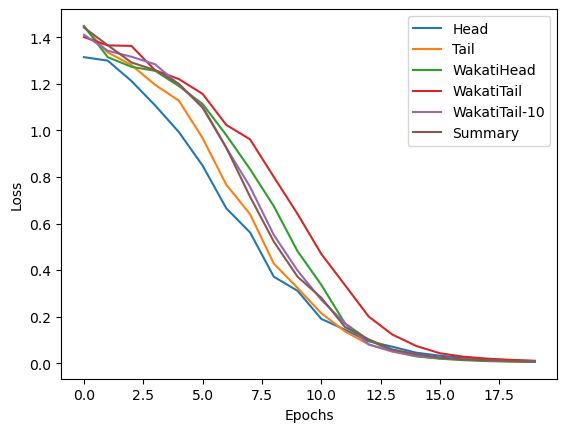

In [55]:
import matplotlib.pyplot as plt

plt.plot(range(len(H_train_loss)), H_train_loss, label="Head")
plt.plot(range(len(T_train_loss)), T_train_loss, label="Tail")
plt.plot(range(len(A_train_loss)), A_train_loss, label="WakatiHead")
plt.plot(range(len(K_train_loss)), K_train_loss, label="WakatiTail")
plt.plot(range(len(KK_train_loss)), KK_train_loss, label="WakatiTail-10")
plt.plot(range(len(S_train_loss)), S_train_loss, label="Summary")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig("ens_augens-re2-fig-"+filestr+".png", format="png", dpi=300)
plt.show()